In [57]:
# Install python openweather package
!pip install pyowm

    100% |████████████████████████████████| 3.7MB 176kB/s eta 0:00:01
  Running setup.py bdist_wheel for pyowm ... done
  Stored in directory: /Users/Andii/Library/Caches/pip/wheels/7d/db/1c/f7e9bca61954a2c69d6d1179a3e0ac7b87424e989816171f78
Successfully built pyowm


In [6]:
import pandas as pd
import requests
import json
from configparser import ConfigParser

%matplotlib inline

# Let's get the data

In [5]:
# Be sure to hide API keys and your serial from Github
# Create a config.ini file with the following content
# [auth]  
# serial = yourSerial123
# token = yourAPIKey123

config = ConfigParser()  
config.read('config.ini')  
token = config.get('auth', 'token')  
serial = config.get('auth', 'serial') 


# Get data from Clairy API
base_url = "http://api.clairy.co/api/Device/GetAllData"

serial = "261700143"
start_date = "2017-08-01"
endpoint = base_url + "?Serial=" + serial + "&StartDate=" + start_date

headers = {"Authorization": "Bearer " + token}
json_data = requests.get(endpoint, headers = headers).json()

In [160]:
# Get historical data from Wunderground
wunder = 'https://www.wunderground.com/weatherstation/WXDailyHistory.asp?ID=IMUNICH268&graphspan=month&month=8&day=1&year=2017&format=1'
hist_weather = pd.read_csv(wunder)

# Formatting the data

In [4]:
# Clairy
json_str = json.dumps(json_data)
data = pd.read_json(json_str)
data.set_index('Date', inplace=True)
data.drop(['Device', 'Serial', 'FanIsOn'], axis=1, inplace=True)
data = data[data.index < '2017-09-01']

data.columns = ['Inside_Humidity', 'Inside_IAQ', 'Inside_Temperature']

# Average daily temperature
data = data.resample('D').mean()

data.tail()

,Inside_Humidity,Inside_IAQ,Inside_Temperature
Date,,,
2017-08-27,75.894444,965.972222,23.022222
2017-08-28,84.143750,856.597222,22.816667
2017-08-29,80.352778,896.180556,22.525694
2017-08-30,82.295833,884.027778,22.855556
2017-08-31,85.270833,877.083333,22.463194


In [161]:
# Wunderground

hist_weather = hist_weather[hist_weather['Date'] != '<br>']
hist_weather.Date = pd.to_datetime(hist_weather.Date)
hist_weather.set_index('Date', inplace=True)
hist_weather = hist_weather[['TemperatureAvgC','HumidityAvg']]
hist_weather.columns = ['Outside_Temperature', 'Outside_Humidity']
hist_weather.head()

,Outside_Temperature,Outside_Humidity
Date,,
2017-08-01,30.1,60.0
2017-08-02,26.2,75.0
2017-08-03,27.4,62.0
2017-08-04,25.7,65.0
2017-08-05,25.9,62.0


# Join the data

In [159]:
joined = data.join(hist_weather, how='outer')
joined.describe()

,Inside_Humidity,Inside_IAQ,Inside_Temperature,Outside_Temperature,Outside_Humidity
count,31.000000,31.000000,31.000000,31.000000,31.000000
mean,80.887142,955.477151,21.712321,22.867742,68.451613
std,6.631523,39.238744,1.296835,3.910276,7.753875
min,68.675000,856.597222,18.288889,13.700000,58.000000
25%,76.523264,945.659722,21.145833,19.950000,62.000000
50%,82.733333,964.930556,21.914583,23.700000,66.000000
75%,84.821528,979.166667,22.788542,25.600000,73.500000
max,92.800694,1000.000000,23.319444,30.100000,88.000000


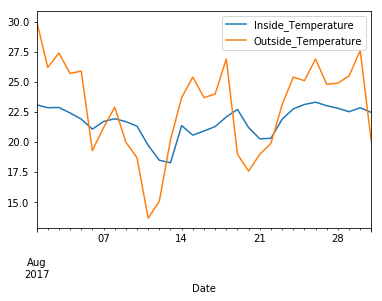

In [156]:
joined[['Inside_Temperature', 'Outside_Temperature']].plot.line()

In [158]:
joined.describe()

,Inside_Humidity,Inside_IAQ,Inside_Temperature,Outside_Temperature,Outside_Humidity
count,31.000000,31.000000,31.000000,31.000000,31.000000
mean,80.887142,955.477151,21.712321,22.867742,68.451613
std,6.631523,39.238744,1.296835,3.910276,7.753875
min,68.675000,856.597222,18.288889,13.700000,58.000000
25%,76.523264,945.659722,21.145833,19.950000,62.000000
50%,82.733333,964.930556,21.914583,23.700000,66.000000
75%,84.821528,979.166667,22.788542,25.600000,73.500000
max,92.800694,1000.000000,23.319444,30.100000,88.000000
